# Chinese characters generator 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, Conv2D

from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


## Data

In [3]:
filename = "./data/vector300_2hier64x64_19_01_18_00_01_35.txt"

X_vec = []
Y_img = []

img_size = 64
wcount = 0
for line in open(filename):
    vec, img = line[:-1].split(",")
    
    vec = np.array([float(n) for n in vec.split(" ")])
    img = np.array([float(n) / 255 for n in img.split(" ")])
        
    img = np.reshape(img, (img_size, img_size, 1))
    
    X_vec.append(vec)
    Y_img.append(img)
    
    wcount += 1
    if (wcount % 10000 == 0):
        print("{} words processed".format(wcount))
        
print("{} words processed".format(wcount))

Y_img = np.array(Y_img)
X_vec = np.array(X_vec)

10000 words processed
20000 words processed
30000 words processed
40000 words processed
50000 words processed
60000 words processed
70000 words processed
80000 words processed
90000 words processed
100000 words processed
110000 words processed
120000 words processed
130000 words processed
140000 words processed
150000 words processed
160000 words processed
170000 words processed
180000 words processed
190000 words processed
198853 words processed


In [4]:
Y_img.shape

(198853, 64, 64, 1)

## Visualisation

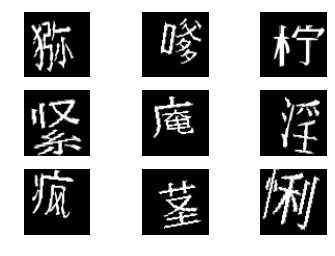

In [5]:
images = Y_img[np.random.randint(0, Y_img.shape[0], 
                                 size=9)]

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i].reshape(img_size, img_size), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

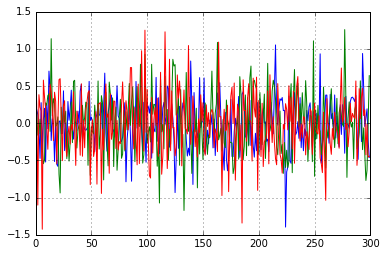

In [6]:
vectors = X_vec[np.random.randint(0, X_vec.shape[0], 
                                  size=3)]

for i in range(3):
    plt.plot(vectors[i])
    
plt.grid()
plt.show()

# GAN
## Generator

In [14]:
gen_dropout = 0.3
gen_input_dim = 8
gen_depth = 256
gen_noise_dim = 300

In [15]:
gennet = Sequential()

# Input 
# fully-connected layer
gennet.add(Dense(gen_input_dim * gen_input_dim * gen_depth, 
                 input_dim=gen_noise_dim))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))
gennet.add(Reshape((gen_input_dim, gen_input_dim, gen_depth)))
gennet.add(Dropout(gen_dropout))

# Deconvolution layers
gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(Conv2DTranspose(int(gen_depth / 16), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

# Output
gennet.add(Conv2DTranspose(1, 5, padding='same'))
gennet.add(Activation('tanh'))

gennet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16384)             4931584   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
activation_13 (Activation)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 128)       819328    
__________

## Discriminator

In [16]:
disc_depth = 64
disc_dropout = 0.3

discnet = Sequential()

# Input
discnet.add(Conv2D(disc_depth, 5, strides=2, input_shape=(64, 64, 1), 
                   padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*2, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*4, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*8, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*16, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

# Out: scalar estimation of probability
discnet.add(Flatten())
discnet.add(Dense(1))
discnet.add(Activation('sigmoid'))

discnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
activation_20 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 256)         819456    
__________

## Discriminator model

In [17]:
discmodel = Sequential()
discmodel.add(discnet)
discmodel.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0002, clipvalue=1.0, decay=6e-8),
                  metrics=['accuracy'])

## Adversarial model

In [21]:
advmodel = Sequential()
advmodel.add(gennet)
advmodel.add(discnet)
advmodel.compile(loss='binary_crossentropy', 
                 optimizer=RMSprop(lr=0.0001, clipvalue=1.0, decay=3e-8),
                 metrics=['accuracy'])

## Training

In [22]:
batch_size = 512
train_iters = 500

disc_losses = {"loss": [], "acc": []}
adv_losses = {"loss": [], "acc": []}
log_i = 0

for i in range(train_iters):
    # Get random real images
    images_true = Y_img[np.random.randint(0, 
                                          Y_img.shape[0], 
                                          size=batch_size)]
    # Generate images from noise
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    images_fake = gennet.predict(noise)
    # Compose training data for discriminator
    x = np.concatenate((images_true, images_fake))
    y = np.concatenate((np.ones((batch_size, 1)), 
                        np.zeros((batch_size, 1))))
    # Train discriminator on composed data
    dics_loss = discmodel.train_on_batch(x, y)
    disc_losses["loss"].append(dics_loss[0])
    disc_losses["acc"].append(dics_loss[1])
    
    # Compose trainig data for adversarial net
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    y = np.ones([batch_size, 1])
    # Train adversarial net on composed data
    adv_loss = advmodel.train_on_batch(noise, y)
    adv_losses["loss"].append(adv_loss[0])
    adv_losses["acc"].append(adv_loss[1])
    
    # Print results
    if i % 10 == 0:
        print("{:4d}th batch of {:4d}|".format(i, train_iters) + \
              "Disc loss {:.3f} |Disc acc {:.3f} |Adv loss {:.3f} |Adv acc {:.3}".format(dics_loss[0], 
                                                                                         dics_loss[1], 
                                                                                         adv_loss[0], 
                                                                                         adv_loss[1]))

   0th batch of  500|Disc loss 0.295 |Disc acc 0.929 |Adv loss 0.734 |Adv acc 0.373
  10th batch of  500|Disc loss 0.530 |Disc acc 0.501 |Adv loss 0.671 |Adv acc 0.717
  20th batch of  500|Disc loss 0.546 |Disc acc 0.508 |Adv loss 0.706 |Adv acc 0.363
  30th batch of  500|Disc loss 0.664 |Disc acc 0.501 |Adv loss 1.016 |Adv acc 0.0
  40th batch of  500|Disc loss 0.782 |Disc acc 0.499 |Adv loss 1.738 |Adv acc 0.0
  50th batch of  500|Disc loss 2.092 |Disc acc 0.500 |Adv loss 2.231 |Adv acc 0.0
  60th batch of  500|Disc loss 0.478 |Disc acc 0.809 |Adv loss 0.844 |Adv acc 0.0234
  70th batch of  500|Disc loss 0.387 |Disc acc 0.933 |Adv loss 1.145 |Adv acc 0.0
  80th batch of  500|Disc loss 0.774 |Disc acc 0.500 |Adv loss 1.614 |Adv acc 0.0
  90th batch of  500|Disc loss 0.626 |Disc acc 0.524 |Adv loss 1.060 |Adv acc 0.0
 100th batch of  500|Disc loss 0.511 |Disc acc 0.639 |Adv loss 1.133 |Adv acc 0.0
 110th batch of  500|Disc loss 1.061 |Disc acc 0.500 |Adv loss 3.411 |Adv acc 0.0
 120th 

KeyboardInterrupt: 

## An attempt to generate images

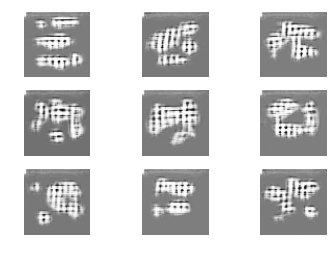

In [26]:
noise = np.random.uniform(-1.0, 1.0, size=[10, gen_noise_dim])
fake_images = gennet.predict(noise)

    
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(fake_images[i].reshape(64, 64), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

## Discriminator losses

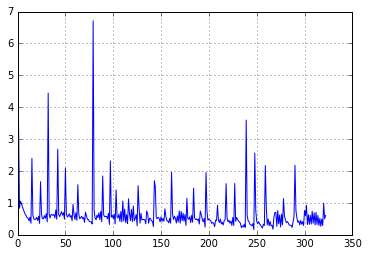

In [24]:
plt.plot(disc_losses["loss"])
plt.grid()

## Adversarial net losses

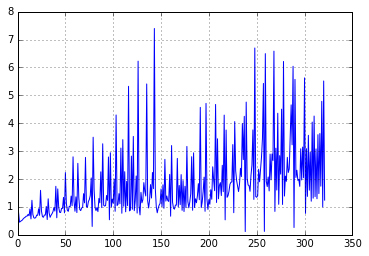

In [25]:
plt.plot(adv_losses["loss"])
plt.grid()